In [1]:
import os
os.chdir("../../../")

In [2]:
import scanpy as sc
import surgeon
import numpy as np

Using TensorFlow backend.
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mohsen/miniconda3

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)

In [4]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Drop-seq", 'inDrops']

# Loading 6 PBMC datasets and data preparation

In [5]:
adata = sc.read("./data/pbmc/pbmc_normalized.h5ad")
adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 107224 × 1793 
    obs: 'CBC', 'CellType', 'Experiment', 'Method', 'batch', 'bulk_labels', 'cell_type', 'louvain', 'method', 'n_counts', 'n_genes', 'percent_mito', 'study', 'size_factors'

## Number of cells in each batch & cell type

In [6]:
adata.obs[condition_key].value_counts()

10x PBMC 68k         68579
10X_3prime            8081
10X_5prime            7371
inDrops               6584
Drop-seq              6584
10x Chromium V2 B     3222
10x Chromium V2 A     3222
10x PBMC 3k           2638
Smart-seq2             526
CEL-Seq2               417
Name: study, dtype: int64

In [7]:
adata.obs[cell_type_key].value_counts()

CD8-T                     36865
CD4-T                     30520
CD14-Mono                 11377
Cytotoxic-T                6094
B                          5981
CD56-NK                    5859
CD19-B                     3817
Dendritic                  2183
NK                         1897
Megakaryocyte               755
F-Mono                      714
CD16-Mono                   653
CD34                        262
Plasmacytoid-Dendritic      247
Name: cell_type, dtype: int64

## Now we leave out one study  (Drop-seq) for training the newtork

In [8]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 94056 × 1793 
    obs: 'CBC', 'CellType', 'Experiment', 'Method', 'batch', 'bulk_labels', 'cell_type', 'louvain', 'method', 'n_counts', 'n_genes', 'percent_mito', 'study', 'size_factors'

In [9]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 13168 × 1793 
    obs: 'CBC', 'CellType', 'Experiment', 'Method', 'batch', 'bulk_labels', 'cell_type', 'louvain', 'method', 'n_counts', 'n_genes', 'percent_mito', 'study', 'size_factors'

## Train/Test Split

In [10]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.80)

In [11]:
train_adata.shape, valid_adata.shape

((75244, 1793), (18812, 1793))

In [12]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [13]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             architecture=[128],
                             use_batchnorm=True,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=1e-3,
                             beta=0.0,
                             eta=1.0,
                             clip_value=100.0,
                             loss_fn='mse',
                             model_path="./models/CVAE/pbmc/mse/before/",
                             dropout_rate=0.0,
                             output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1793)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 8)            0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 128)          230528      data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None

## We assign each study to a numerical label 

In [14]:
conditions = adata.obs[condition_key].unique().tolist()

In [15]:
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)

## Training the network

In [ ]:
network.train(train_adata,
              valid_adata,
              condition_key=condition_key,
              cell_type_key=cell_type_key,
              le=condition_encoder,
              n_epochs=10000,
              batch_size=128,
              early_stop_limit=100,
              lr_reducer=80,
              n_per_epoch=0,
              save=True,
              retrain=True,
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 75244 samples, validate on 18812 samples
Epoch 1/10000
 - 12s - loss: 135.7952 - reconstruction_loss: 135.7949 - mmd_loss: 0.0000e+00 - val_loss: 148.4967 - val_reconstruction_loss: 148.4965 - val_mmd_loss: 0.0000e+00
Epoch 2/10000
 - 8s - loss: 112.4440 - reconstruction_loss: 112.4437 - mmd_loss: 0.0000e+00 - val_loss: 171.1057 - val_reconstruction_loss: 171.1054 - val_mmd_loss: 0.0000e+00
Epoch 3/10000
 - 8s - loss: 109.5223 - reconstruction_loss: 109.5220 - mmd_loss: 0.0000e+00 - val_loss: 207.9817 - val_reconstruction_loss: 207.9813 - val_mmd_loss: 0.0000e+00
Epoch 4/10000
 - 8s - loss: 108.1610 - reconstruction_loss: 108.1607 - mmd_loss: 0.0000e+00 - val_loss: 226.5096 - val_reconstruction_loss: 226.5092 - val_mmd_loss: 0.0000e+00
Epoch 5/10000
 - 8s - loss: 107.3174 - reconstruction_loss: 107.3170 - mmd_loss: 0.0000e+00 - val_loss: 244.9221 - val_reconstruction_loss: 244.9217 - val_mmd_loss: 0.0000e+00
Epoch 6/10000
 - 8s -

In [18]:
network.condition_encoder

{'10x Chromium V2 A': 0,
 '10x Chromium V2 B': 1,
 'CEL-Seq2': 2,
 'Smart-seq2': 3,
 '10X_5prime': 4,
 '10X_3prime': 5,
 '10x PBMC 68k': 6,
 '10x PBMC 3k': 7}

In [19]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [21]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 75244 × 10 
    obs: 'CBC', 'CellType', 'Experiment', 'Method', 'batch', 'bulk_labels', 'cell_type', 'louvain', 'method', 'n_counts', 'n_genes', 'percent_mito', 'study', 'size_factors'

In [22]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/mohsen/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


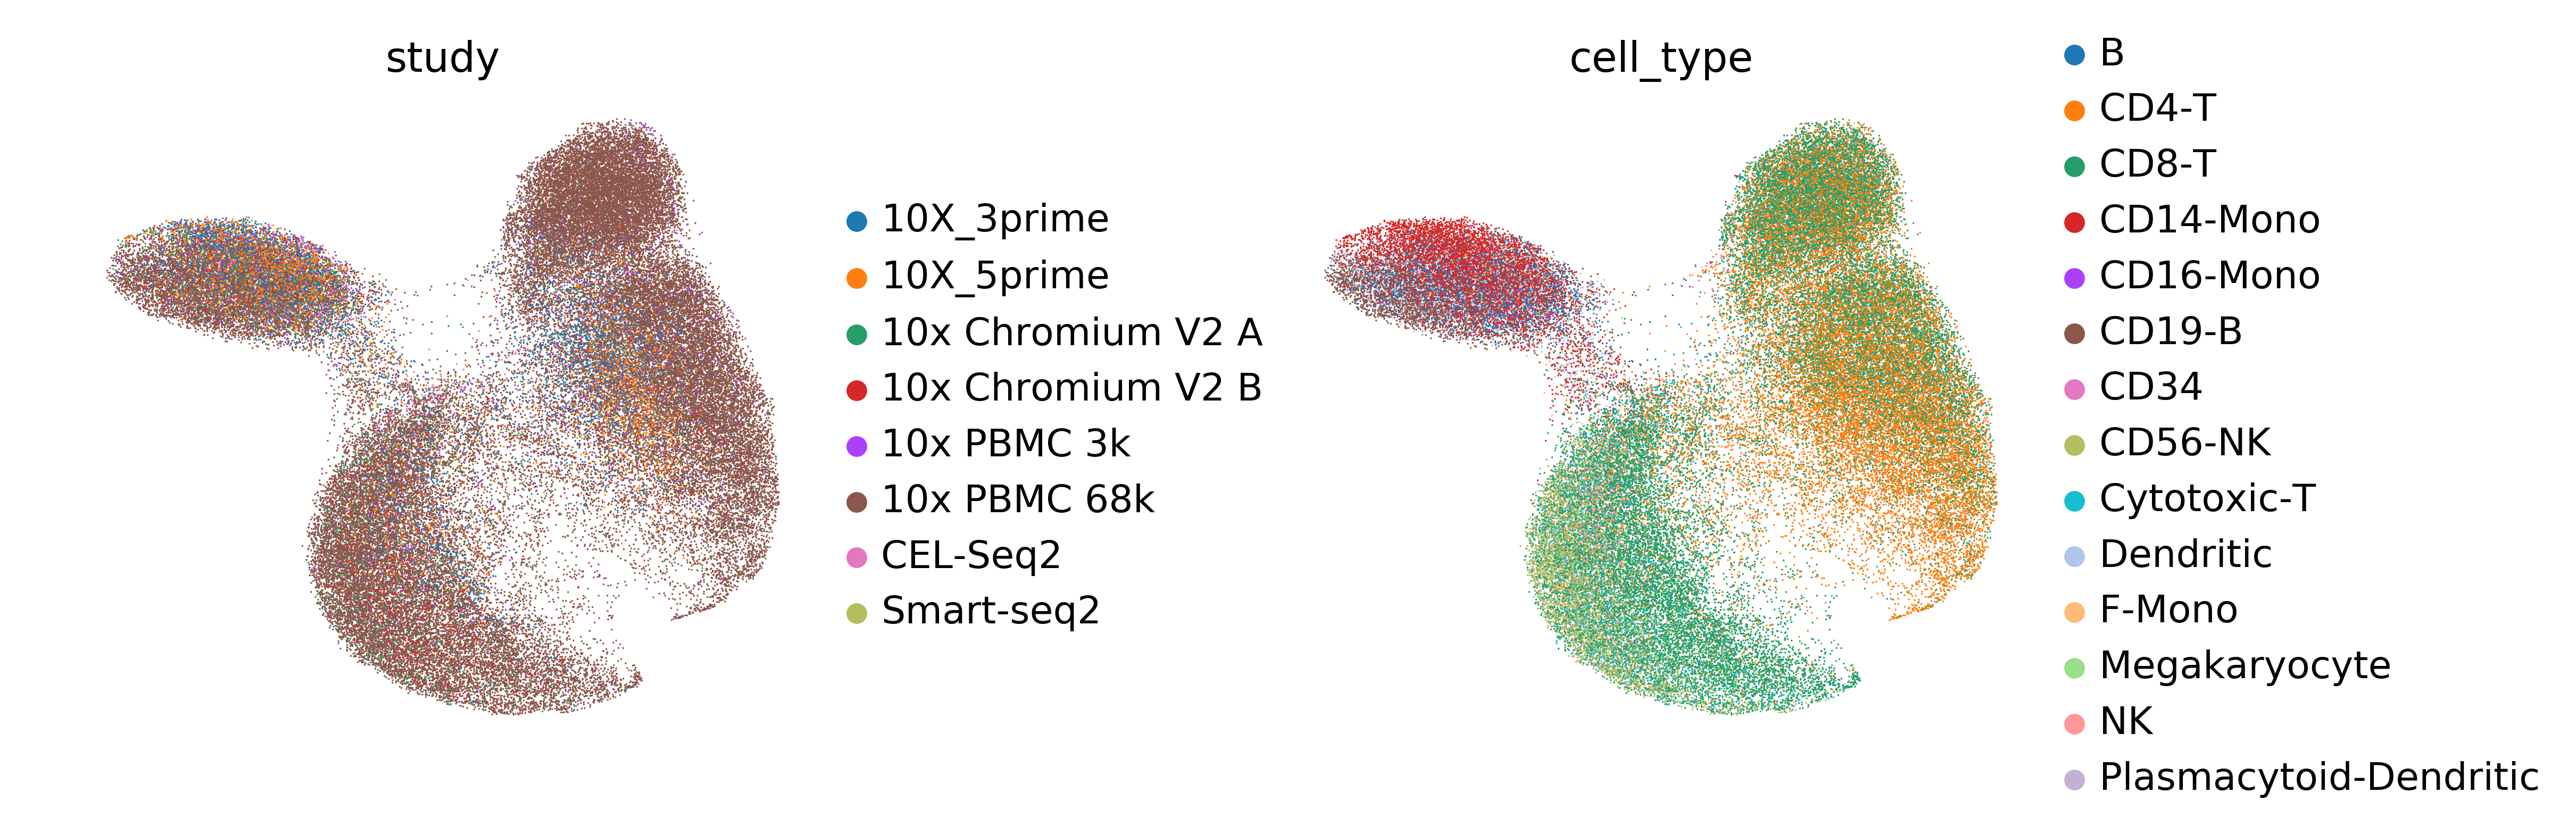

In [23]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [24]:
surgeon.metrics.entropy_batch_mixing(latent_adata, n_neighbors=15, label_key=condition_key)

0.5363074956086932

In [25]:
surgeon.metrics.knn_purity(latent_adata, n_neighbors=15, label_key=cell_type_key)

0.2898888376334467

In [23]:
network.save_model()

# Perfroming architecture Surgery

In [19]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              remove_dropout=True,
                              init='Xavier', 
                              freeze=True,
                              freeze_expression_input=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1793)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 10)           0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 128)          230784      data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_3 (LeakyReLU)       (None, 128)          0           first_layer[0][0]                
__________

In [ ]:
network.save_model()

In [20]:
new_network.condition_encoder

{'10x Chromium V2 A': 0,
 '10x Chromium V2 B': 1,
 'CEL-Seq2': 2,
 'Smart-seq2': 3,
 '10X_5prime': 4,
 '10X_3prime': 5,
 '10x PBMC 68k': 6,
 '10x PBMC 3k': 7,
 'Drop-seq': 8,
 'inDrops': 9}

## Train with small new dataset containing out-of-sample condition

In [21]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.80)

In [22]:
train_adata.shape, valid_adata.shape

((10534, 1793), (2634, 1793))

In [ ]:
new_network.train(train_adata,
                  valid_adata,
                  condition_key=condition_key,
                  cell_type_key=cell_type_key,
                  le=new_network.condition_encoder,
                  n_epochs=10000,
                  batch_size=1024,
                  n_epochs_warmup=0,
                  early_stop_limit=100,
                  lr_reducer=80,
                  n_per_epoch=0,
                  save=False,
                  retrain=True,
                  verbose=2)

In [ ]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [ ]:
adata_out_of_sample.obs[condition_key].value_counts()

In [ ]:
latent_adata = new_network.to_mmd_layer(adata_out_of_sample, encoder_labels, encoder_labels)
latent_adata

In [ ]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

In [ ]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [ ]:
surgeon.metrics.entropy_batch_mixing(latent_adata, n_neighbors=15, label_key=condition_key)

In [ ]:
surgeon.metrics.knn_purity(latent_adata, n_neighbors=15, label_key=cell_type_key)

In [ ]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_for_training, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [ ]:
latent_adata = new_network.to_mmd_layer(adata_for_training, encoder_labels, encoder_labels)
latent_adata

In [ ]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

In [ ]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [ ]:
surgeon.metrics.entropy_batch_mixing(latent_adata, n_neighbors=15, label_key=condition_key)

In [ ]:
surgeon.metrics.knn_purity(latent_adata, n_neighbors=15, label_key=cell_type_key)